## Problem Definition

**Initial goal**: Develop a competitive edge for fantasy football by predicting player outcomes.  
Considerations: 
<br>

1. There are 3 main tasks that require decisions: drafting players, trading players, starting/sitting players. *Focus first on drafting since this decision only requires predicting player points without considering other interactions.* <br>

2. There are 4 main positions that will likely have different predictive factors: wide receivers, running backs, tight ends, and quarterbacks. *Focus first on wide receivers since each team can have 3 of them and there will be the most data since there are more receivers than running backs.*
<br>

**Revised goal**: Develop a competitive edge in drafting by predicting wide receiver outcomes.  
Considerations: <br>

3. Determine a baseline to measure improvement. *Define current state as drafting based on ADP (Average draft position of a given player based off all the drafts done by all leagues on a given platform).*
4. Determine attribute to predict. *Predict points per game played. This will avoid modeling errors when considering past injuries. Since injuries are not predictable, the most relevant information is the points scored per game, not total points scored. This will potentially allow the model to be extended to in-season predictions for trading and starting/sitting because points per game should still apply no matter how many games are left in the season.*
5. Determine if rookie performance can be predicted.  *not enough data in current data set.  Rookies are removed from model for now.  May be able to predict based on college performance and/or NFL draft position*
<br>

**Final goal**: Develop a model to predict non-rookie wide receiver points per game that outperforms drafting based on ADP.


## Data Acquisition

### Data Source
**Data Source: Pro Football Focus**

-	Includes historical data for all wide receivers per game for more than the last 10 years
-	Includes multiple types of detailed data to extract maximum insight
    -	basic statistical values such as yards, targets, touchdowns
    -	compound statistical values such as targeted quarterback rating, yards per route run, inline rate
    -	proprietary player grades metric which aggregates player performance on each play

### Clean Data
Create function to pull data in.  Using a function will make sure that I can always access clean data input after manipulating the data frame for various uses.<br>
cleaning steps: <br>

1.	Filter attributes
    1.	Using subject matter expertise, remove irrelevant data
    2.	remove absolute data when rate data is available
    3.	remove repetitive data that could be concluded from other data
2.	import data
    1.	filter out non-wider receivers
    2.	filter out the lowest percentiles of receivers
        1.	Many players are irrelevant to fantasy and including them would significantly weight the data towards low points per game
        2.	 Determine cutoff percentile by picking a value that excludes as many players as possible while still including most players from the ADP dataset. (this is a separate dataset that includes players ADP to be used for assessing predictive capability)
3.	For each player’s outcome for each year combine data for all previous years to collect independent and dependent values in each row.
4.	Each input column will expand into a column containing: the mean, standard deviation and slope as well as one column for each of the previous 6 years.  


In [504]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# identify columns that should be relevant to prediction
relevant_columns = [
    'player',
    'player_id',
    'position',
    'team_name',
    'player_game_count',
    'avg_depth_of_target',
    'caught_percent',
    'contested_catch_rate',
    'drop_rate',
    'first_downs',
    'grades_offense',
    'inline_rate',
    'pass_plays',
    'route_rate',
    'slot_rate',
    'targeted_qb_rating',
    'targets',
    'touchdowns',
    'yards',
    'yards_after_catch_per_reception',
    'yards_per_reception',
    'yprr']
# name columns that will need to be added
# calculate fantasy points
# calculate statistics per game for relevant attributes
per_game_columns = [
    'fpts', 
    'targets', 
    'touchdowns',
    'first_downs',
    'pass_plays',
    'yards']
new_columns = [
    'fpts', 
    'fpts_game', 
    'targets_game', 
    'touchdowns_game',
    'first_downs_game',
    'pass_plays_game',
    'yards_game']

def import_history (years, columns=relevant_columns, new_columns=new_columns, replace=np.nan, remove_lists=True, targ_quant=0.25, expo_updates=True):
    '''
    import: one csv file for each year
    return: in a dict with each dataframe
    '''
    dataframes = {}
    # import each dataframe
    for year in years:
        location = 'Yearly\\' + str(year) + '.csv'
        df = pd.read_csv(location)
        df = df[df['position'] == 'WR']
        df = df[df['targets'] >= df['targets'].quantile(targ_quant)]
        
        # calcualte fantasy points
        df['fpts'] = df['receptions'] * 0.5 + df['yards'] * 0.1 + df['touchdowns'] * 6
        # calculate per game metrics
        for attribute in per_game_columns:
                new_att_name = attribute + '_game'
                df[new_att_name] = df[attribute] / df['player_game_count']

        # remove irrelevant columns
        df_columns = columns + new_columns
        df = df[df_columns]
        # add column to track year
        df['year'] = year
        # add dataframe to dictionary
        dataframes[year] = df
    
    #combine all csvs into one
    wr_data = pd.concat(list(dataframes.values()))
    wr_data_names = pd.DataFrame(wr_data['player'].unique()).copy()
    wr_data_names.columns = ['player']

    #select numeric data columns
    data_columns = list(df.select_dtypes(include=[np.number]).columns)
    data_columns.remove('player_id')
    data_columns.remove('year')

    #aggregate data by creating a list of all values for each stat that occured before the given year
    wr_df_list = []
    for year in years:
        if year == 2018: continue
        wr_data_split = wr_data_names.copy()
        for column in data_columns:
                df = wr_data[wr_data['year'] < year].groupby('player')[column].apply(list).reset_index()
                wr_data_split = pd.merge(wr_data_split, df, 'inner', 'player')
        wr_data_split['year'] = year
        wr_df_list.append(wr_data_split)

    #store raw values here
    wr_data_raw = pd.concat(wr_df_list).reset_index(drop=True)
    wr_data_raw = pd.merge(wr_data_raw, wr_data[['player', 'year', 'fpts_game']], 'left', ['player', 'year'])
    wr_data_raw.rename(columns={'fpts_game_x': 'fpts_game', 'fpts_game_y': 'fpts_game_actual'}, inplace=True)
    wr_data_raw = wr_data_raw.dropna(subset=['fpts_game_actual']).reset_index(drop=True)

    #create new dataframe that stores the std, mean and slope for each list of values
    for column in data_columns:
        wr_data_raw[column + '_std'] = np.array(np.std(pd.DataFrame(wr_data_raw[column].tolist()),axis=1))
        wr_data_raw[column + '_mean'] = np.array(np.mean(pd.DataFrame(wr_data_raw[column].tolist()),axis=1))
        wr_data_raw[column + '_slope'] = np.array((np.max(pd.DataFrame(wr_data_raw[column].tolist()),axis=1) 
                            - np.min(pd.DataFrame(wr_data_raw[column].tolist()),axis=1)) 
                            / pd.DataFrame(wr_data_raw[column].tolist()).notna().sum(axis=1))

    # split the values for year such that data is broken into: last year, two years ago...
    if len(years) > 1:
        def year_split(column, input):
            df = input.copy()
            for year in range(6):
                year = (year + 1)
                year_neg = year * -1
                column_name = column + str(year_neg)
                df[column_name] = [x[year_neg] if len(x) >= year else replace for x in df[column]]
            return df
        for column in data_columns:
            wr_data_raw = year_split(column, wr_data_raw)
    if relevant_columns:
        wr_data_raw = wr_data_raw[['player']].join(wr_data_raw.select_dtypes('number'))

    # based on data exploration, fill nulls  with 0
    wr_data_raw = wr_data_raw.fillna(0)

    # based on data exploration, set std limit for noted columns
    if expo_updates:
        std_limit_cols = [
            'drop_rate_mean',
            'inline_rate_mean',
            'yards_after_catch_per_reception_mean',
            'yards_per_reception_mean',
            'yprr_mean']
        for col in std_limit_cols:
            high = wr_data_raw[col].mean() + 3*wr_data_raw[col].std()
            low = wr_data_raw[col].mean() - 3*wr_data_raw[col].std()
            wr_data_raw = wr_data_raw[(wr_data_raw[col] <= high) & (wr_data_raw[col] >= low)]

    wr_data_raw.reset_index(inplace=True,drop=True)

    return wr_data_raw

# function to limit dataframe to one time of data, either absolute yearly or statistical based on all available history
# types: years(values split by year), stats(values split by stats), all
def df_select(input, columns, kind='both', addl_col = []):
    basics = ['player','year','fpts_game_actual'] + addl_col
    years = ['-1','-2','-3','-4','-5','-6']
    stats = ['_std','_mean','_slope']
    both = years + stats
    options = {'years': years,'stats':stats, 'both':both}
    suffixs = options[kind]
    df = input.copy()
    columns = [col + suffix for col in columns for suffix in suffixs]
    columns_all = basics + columns
    df = df[columns_all]
    return df, columns

### Explore Data
Exploration steps

1.	Start by filtering exploration attributes to just the mean values.  This should give a sense of the predictive relevance of each attribute without examining each of the ~200 attribute columns individually.  
2.	Identify null values – either fill or remove
3.	Plot each attribute to see data ranges and identify outliers
    1.	For columns with significant outliers remove data more than 3 standard deviations from the mean
4.	Apply null fill and standard deviation correction to data input function

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import data for exploration
years = [2018,2019,2020,2021,2022,2023,2024]
wr_explore = import_history(years,replace=0)

# based on data exploration, fill null with 0
wr_explore = wr_explore.fillna(0)

# based on data exploration, set std limit for noted columns
# removes 50 rows
std_limit_cols = [
    'drop_rate_mean',
    'inline_rate_mean',
    'yards_after_catch_per_reception_mean',
    'yards_per_reception_mean',
    'yprr_mean']
for col in std_limit_cols:
    high = wr_explore[col].mean() + 3*wr_explore[col].std()
    low = wr_explore[col].mean() - 3*wr_explore[col].std()
    wr_explore = wr_explore[(wr_explore[col] <= high) & (wr_explore[col] >= low)]

# filter dataframe to just mean data
mean_cols = [col for col in wr_explore.columns if '_mean' in col]
explore_cols = mean_cols + ['fpts_game_actual']
wr_explore_mean = wr_explore[explore_cols]

##### Find Nulls
update data import with null replacement

In [811]:
# for each column count nulls
null_list = {}
for col in mean_cols:
    null_list[col] = (wr_explore_mean[col].isnull().sum())
null_list
# contested_catch_rate: 9 null
# investigate null data
nulls = wr_explore[wr_explore['contested_catch_rate_mean'].isnull()]
# data is from low volume players, can replace these null's with 0

##### Plots for each attribute
Histogram with quartiles identified <br>
update data import with standard deviation limits

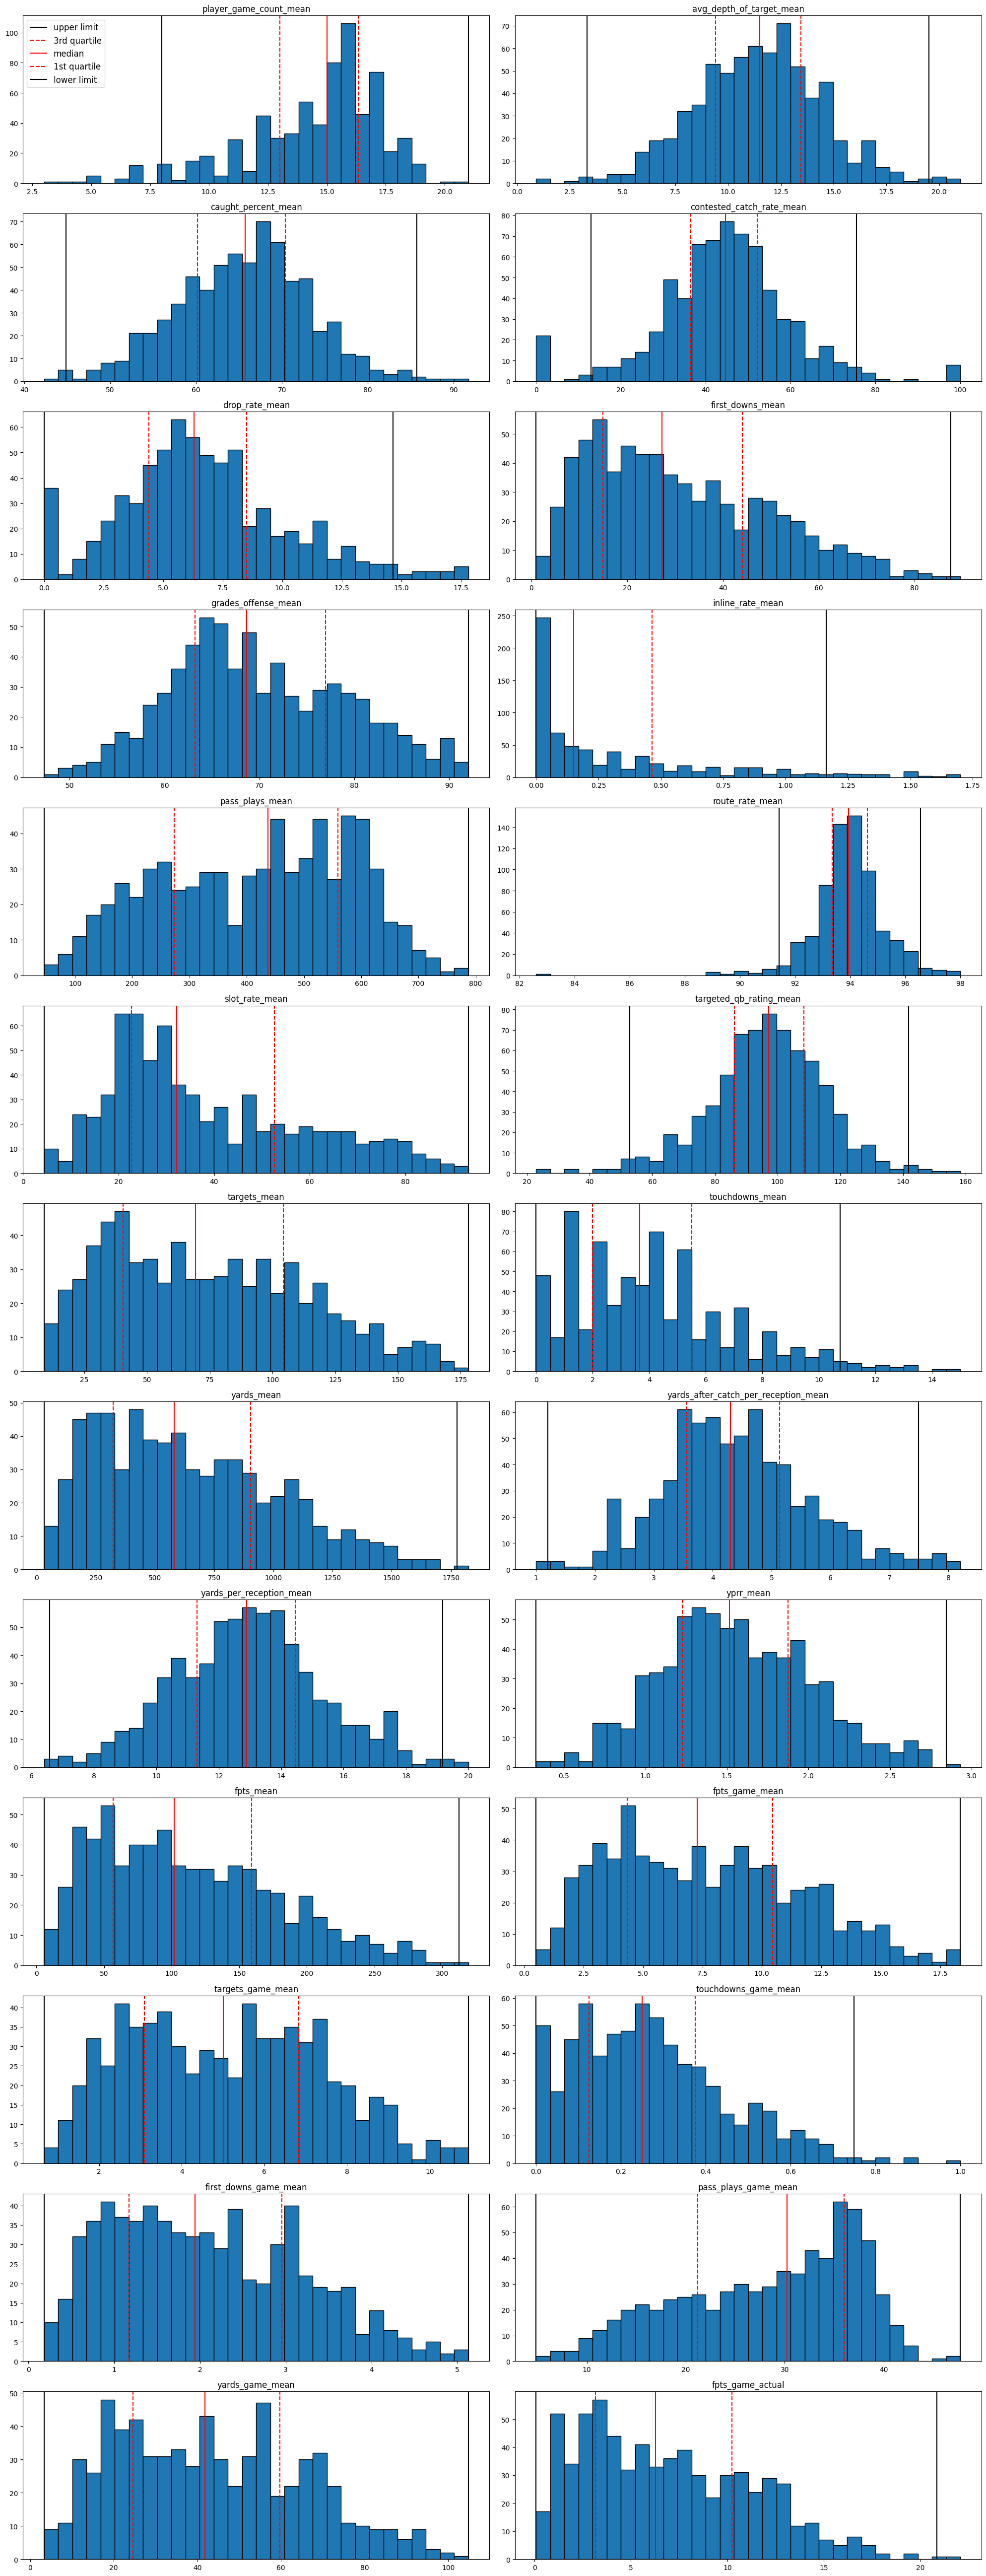

In [64]:
# Number of columns
num_columns = wr_explore_mean.shape[1]

# Create subplots
fig, axes = plt.subplots(nrows=int(num_columns/2), ncols=2, figsize=(20, 2*num_columns))

# Plot each column's histogram
row = 0
col = 0
for i, column in enumerate(wr_explore_mean.columns):
    axes[row, col].hist(wr_explore_mean[column], bins=30, edgecolor='black')
    axes[row, col].set_title(column)

    #plot quartiles
    mid = wr_explore_mean[column].quantile(0.50)
    q1 = wr_explore_mean[column].quantile(0.25)
    q3 = wr_explore_mean[column].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    if upper > wr_explore_mean[column].max(): upper = wr_explore_mean[column].max()
    if lower < wr_explore_mean[column].min(): lower = wr_explore_mean[column].min()
    
    axes[row, col].axvline(x=upper, color='black', label='upper limit')
    axes[row, col].axvline(x=q3, color='r', linestyle='--', label='3rd quartile')
    axes[row, col].axvline(x=mid, color='r', label='median')
    axes[row, col].axvline(x=q1, color='r', linestyle='--', label='1st quartile')
    axes[row, col].axvline(x=lower, color='black', label='lower limit')

    #plot legend on first chart
    if col == 0 and row == 0:
        axes[row, col].legend(loc='upper left', fontsize='large')

    if col == 1:
        col = 0
        row += 1
    else:
        col += 1

plt.tight_layout()

# notes
# contested catch rate mean: nodes at 0, 100
# drop rate: far outliers
# inline rate: far outliers
# yards after catch per reception: far outliers
# yards per reception: far outliers
# yprr: far outliers

### Explore Correlation
Exploration steps

1.	Create heatmap of correlation matrix to see the correlations to the target variable and other independent variables.
2.	Create adjusted correlation to fantasy points by:
    1.	Selecting attribute with highest correlation to target
    2.	Adjust correlation to target based on correlation between selected attribute and all others
    3.	Selecting the next highest attribute
3.	Attributes most independently correlated to points per game:
    1.	Fantasy Points
    2.	Targeted quarterback rating
    3.	Targets per game
    4.	Yards per reception
    5.	Targets

<Axes: title={'center': 'Correlation Heatmap'}>

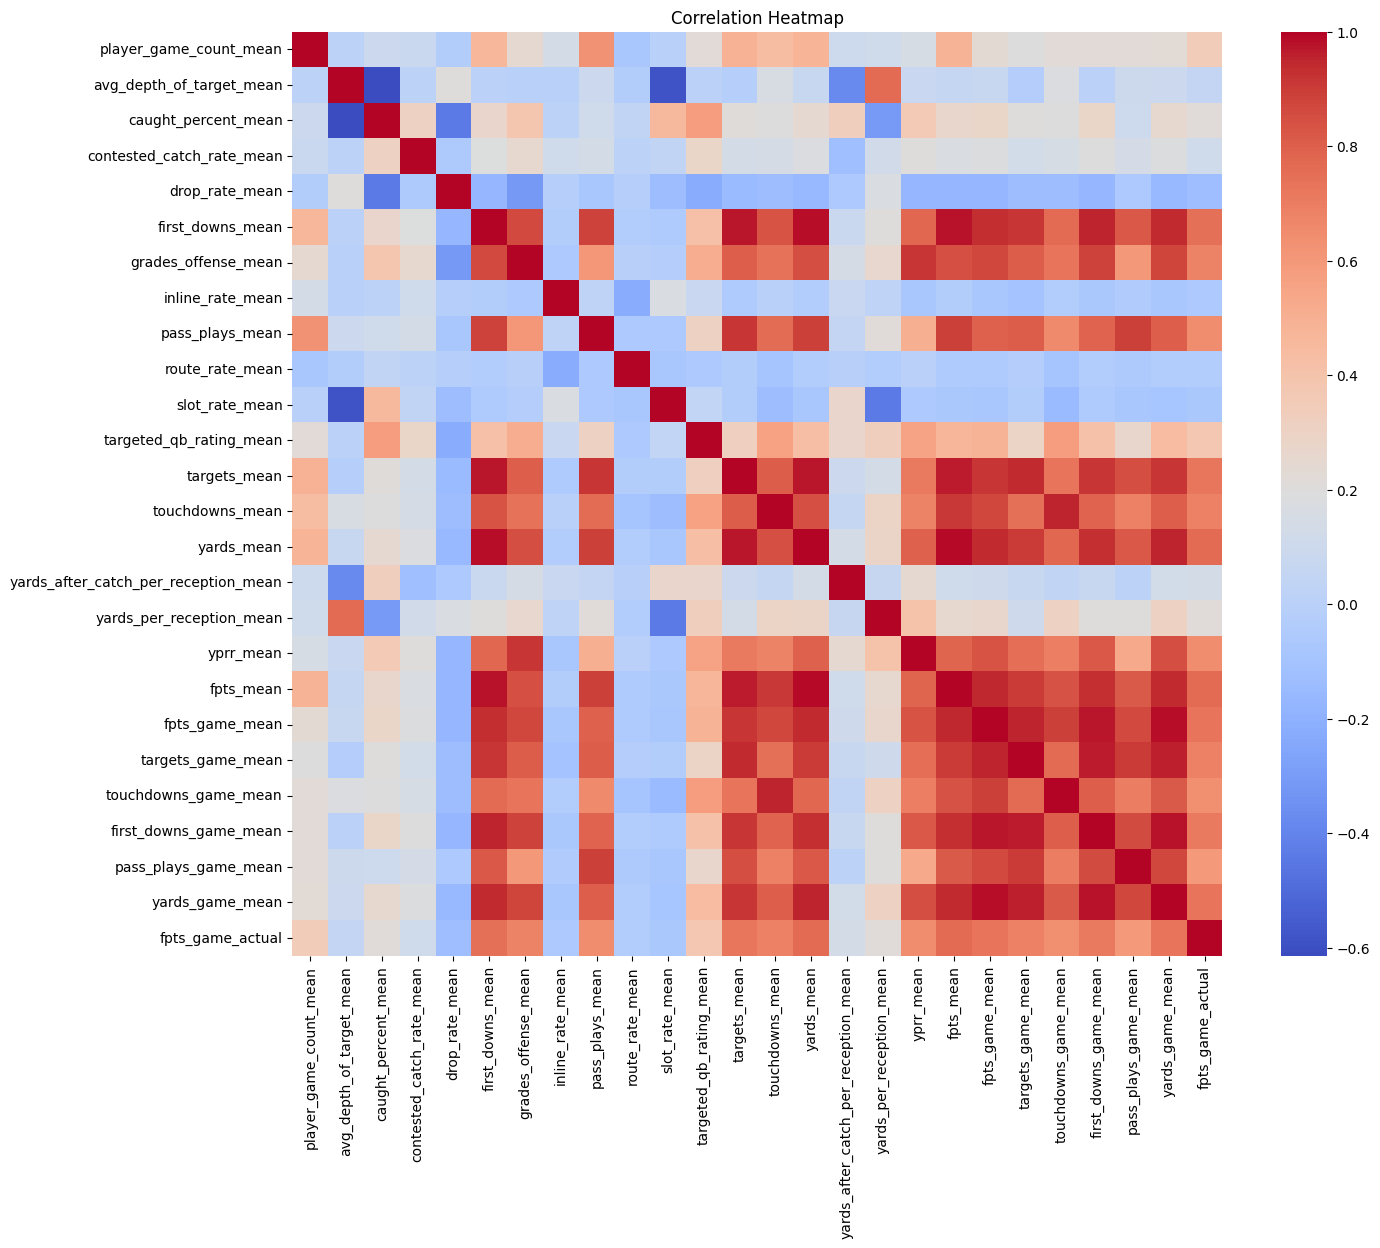

In [134]:
corr_mat = wr_explore_mean.corr()
# corr_mat = corr_mat.sort_values(by='fpts_game_actual',ascending=False)

plt.figure(figsize=(15, 12))
plt.title('Correlation Heatmap')
sns.heatmap(corr_mat, annot=False, cmap='coolwarm')

<BarContainer object of 24 artists>

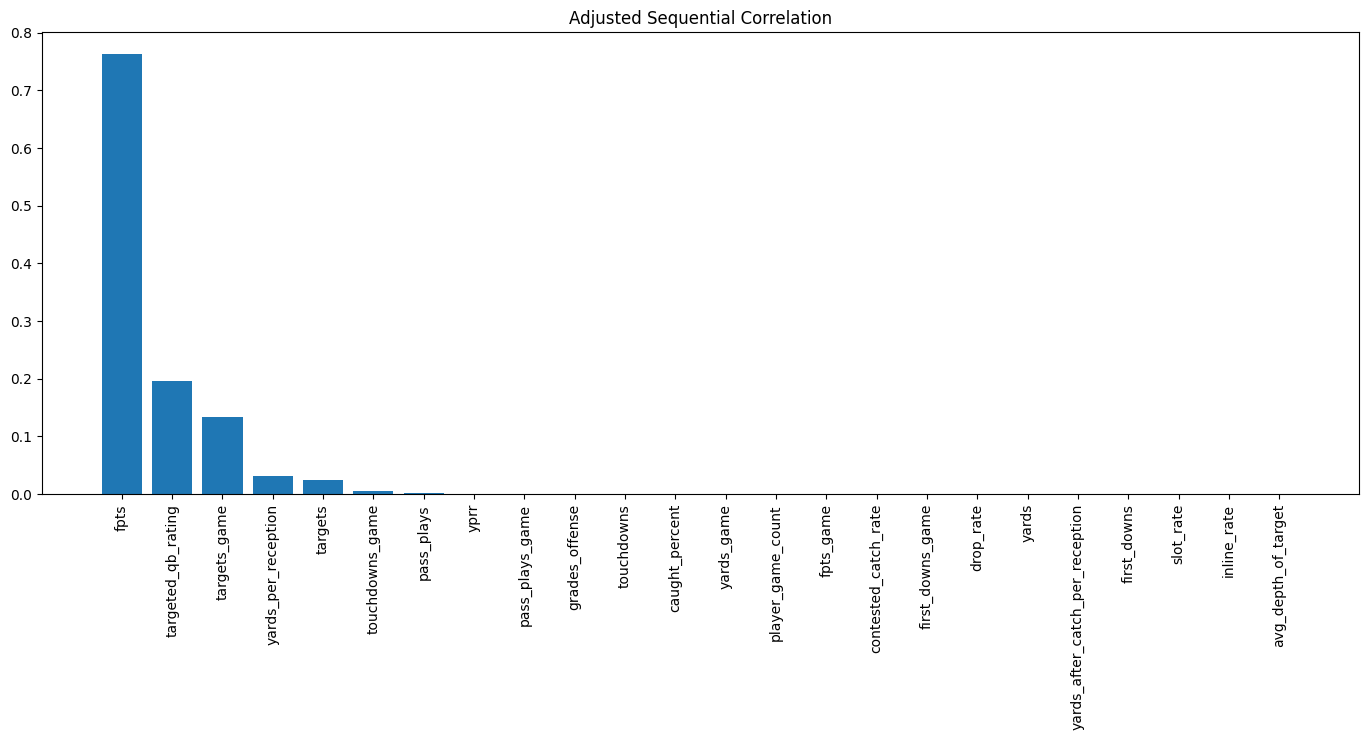

In [135]:
corr_mat = wr_explore_mean.corr()
attributes = len(corr_mat) - 2

# create loop to:
# choose highest attribute with highest correlation to points/game
# adjust correlation based on correlation to last attribute selected
# choose attribute next most correlated to points/game
predictors = {}
corr_mat = np.abs(corr_mat).sort_values(by='fpts_game_actual',ascending=False)
corr_mat = corr_mat.drop(corr_mat.index[0])
for x in range(attributes):
    corr_mat = np.abs(corr_mat).sort_values(by='fpts_game_actual',ascending=False)
    predictor = corr_mat.index[0]
    predictors[predictor] = corr_mat.loc[corr_mat.index == predictor, 'fpts_game_actual'].to_list()[0]
    corr_mat['fpts_game_actual'] = [adj * base for adj,base in zip((1 - corr_mat[predictor])*corr_mat.loc[corr_mat.index == predictor, 'fpts_game_actual'].to_list()[0],corr_mat['fpts_game_mean'])]
    corr_mat = corr_mat.drop(predictor)

# plot adjusted correlation
predictor_str = [value[:-5] for value in predictors.keys()]
plt.figure(figsize=(17,6))
plt.xticks(rotation=90)
plt.title('Adjusted Sequential Correlation')
plt.bar(predictor_str, predictors.values())


- do the same process with all attributes
- values are adjusted for visibility, these adjusted values aren't used for anything except ranking

C:\Users\cowil\AppData\Local\Temp\ipykernel_16184\1539951135.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = wr_explore_full.corr()


['fpts_mean', 'first_downs_game-3', 'yards_game-1', 'touchdowns_game-2', 'grades_offense-1', 'pass_plays_game_mean', 'yprr-1', 'pass_plays_game-1', 'yprr_mean', 'pass_plays_mean', 'grades_offense_mean', 'pass_plays-1', 'touchdowns_game_mean', 'targets_game-2', 'touchdowns_game-1', 'first_downs_game-2', 'touchdowns-1', 'fpts_game-2', 'fpts_game-1', 'yards_game-2']


<BarContainer object of 20 artists>

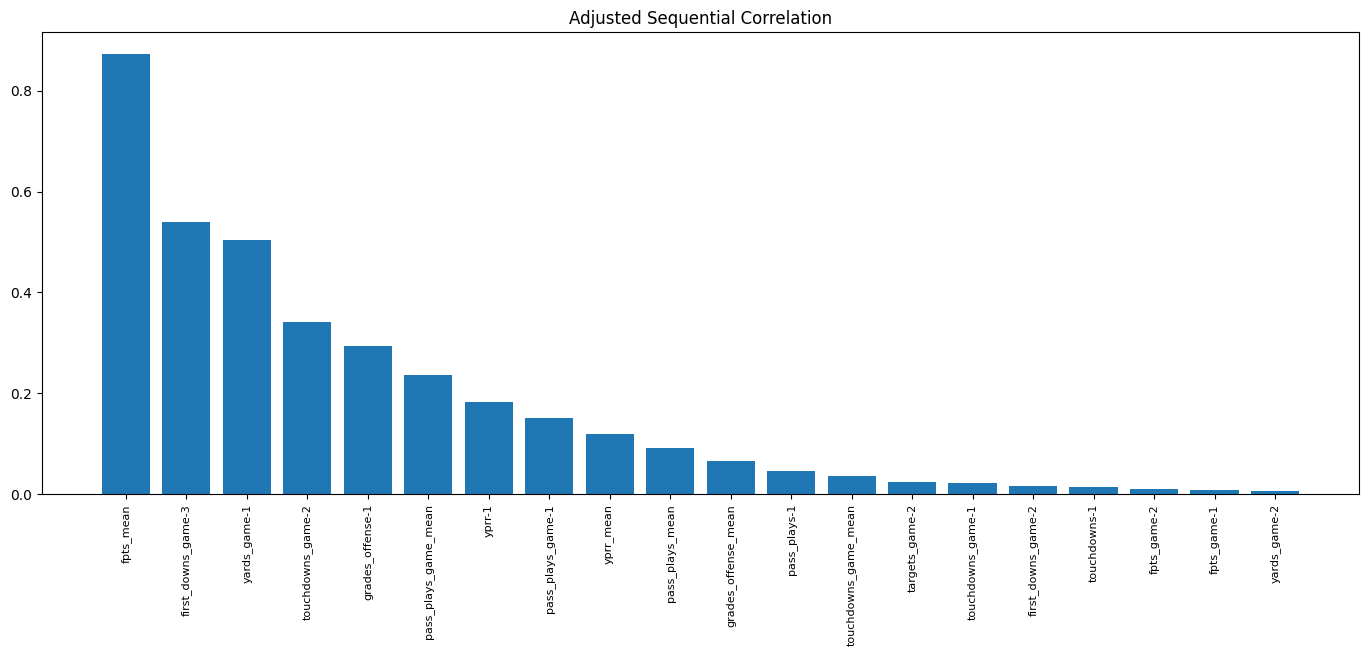

In [325]:
wr_explore_full = import_history(years,replace=0)

corr_mat = wr_explore_full.corr()
attributes = len(corr_mat) - 2

# create loop to:
# choose highest attribute with highest correlation to points/game
# adjust correlation based on correlation to last attribute selected
# choose attribute next most correlated to points/game
predictors = {}
corr_mat = np.abs(corr_mat).sort_values(by='fpts_game_actual',ascending=False)
corr_mat = corr_mat.drop(corr_mat.index[0])
for x in range(attributes):
    corr_mat = np.abs(corr_mat).sort_values(by='fpts_game_actual',ascending=False)
    predictor = corr_mat.index[0]
    predictors[predictor] = np.sqrt(corr_mat.loc[corr_mat.index == predictor, 'fpts_game_actual'].to_list()[0])
    corr_mat['fpts_game_actual'] = [adj * base * 1.5 for adj,base in zip((1 - corr_mat[predictor])*corr_mat.loc[corr_mat.index == predictor, 'fpts_game_actual'].to_list()[0],corr_mat['fpts_game_mean'])]
    corr_mat = corr_mat.drop(predictor)

print(list(predictors.keys())[:20])

# plot adjusted correlation
plt.figure(figsize=(17,6))
plt.xticks(rotation=90,fontsize=8)
plt.title('Adjusted Sequential Correlation')
plt.bar(list(predictors.keys())[:20], list(predictors.values())[:20])

## Modeling

### Attribute selection tool
select the relevant columns that correspond to a given base attribute

In [222]:
def column_select (df, columns, base_cols = ['player', 'fpts_game_actual', 'year']):
    col_list = []
    for string in columns:
        if '_game' not in string:
            col_list = col_list + [column for column in df.columns if (string in column) and ('_game' not in column)]
        else:
            col_list = col_list + [column for column in df.columns if string in column]
        col_list = [col for col in col_list if col != 'fpts_game_actual']
    all_cols = col_list + base_cols
    return df[all_cols], col_list

### Linear Regression

- start by building a linear regression since its a straightforward starting point. <br>
- because 'fantasy points per game mean' has a strong correlation to actual a linear model may be able to predict actual fantasy points per game well.
- best correlation: 0.78

In [595]:
#create function to use for repeated linear regression
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

def lr_predict (df,columns, test_year, target='fpts_game_actual', rand=1, chart=False, stats=False):
    
    all_cols = columns + [target]
    
    # scale data 
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[all_cols]))
    df_scaled['year'] = df.reset_index()['year']

    all_cols = columns + ['fpts_game_actual'] + ['year']
    df_scaled.columns=(all_cols)
        
    # create train/test sets based on testing year
    x_test = df_scaled[df_scaled['year']==test_year][columns].copy()
    y_test = df_scaled[df_scaled['year']==test_year][target].copy()
    x_train = df_scaled[df_scaled['year']!=test_year][columns].copy()
    y_train = df_scaled[df_scaled['year']!=test_year][target].copy()

    lr = LinearRegression()
    lr.fit(x_train[columns], y_train)
    predictions = lr.predict(x_test[columns])
    corr, p = pearsonr(predictions, y_test)
    corr, p = round(corr,3), round(p,3)

    if stats: 
        print('Correlation ',corr)
        print('Pval ',p)

    slope = lr.coef_
    intercept = lr.intercept_

    if chart == True:
        plt.scatter(predictions,y_test)
        x = y = np.arange(min(y_test),max(y_test))
        plt.plot(x, y)
    
    return corr, p , slope, intercept, lr

def lr_cross_val (df,columns, test_years=[2021,2022,2023,2024], print_corr=False):
    corrs = []
    slopes = []
    models = []
    for test_year in test_years:
        corr, _, slope, _, model = lr_predict(df, columns, test_year, chart=False, stats=False)
        corrs.append(corr)
        slopes.append(slope)
        models.append(model)
    print('Average Correlation ',np.mean(corrs))
    return np.prod(slopes,axis=0), models

Start by using just the mean values used in correlation exploration <br>
correlation: 0.76

In [580]:
years = [2018,2019,2020,2021,2022,2023,2024]
wr_linreg = import_history(years,replace=0)
indep_atts = ['fpts_game_mean',
              'targeted_qb_rating_mean',
              'targets_game_mean',
              'yards_per_reception_mean',
              'targets_mean']

In [581]:
# test against all valid testing years
test_years = [2021, 2022, 2023, 2024]

_, lr_models = lr_cross_val(wr_linreg, indep_atts, test_years, print_corr=True)

Average Correlation  0.76225


1. Next Try all the columns associated with the 5 primary attributes - results in 45 columns 
    1. correlation: 0.75 
2. narrow results down by taking attributes with the 20 largest coeficients then reducing to 10, then 5
    1. best results come when using top 10 values
    2. correlation: 0.78 
- This yeilded interesting results.  The regression assigned significant predictive power to the targets per game and the targets from the season 6 years before the test year.  I am not sure this is valid, since most instances won't have data from 6 years ago, but I will keep this for further comparison later.  

In [601]:
test_years = [2021, 2022, 2023, 2024]
columns = [att[:-5] for att in indep_atts]
wr_linreg_2, indep_atts_2 = column_select (wr_explore, columns)

# find the top 20 values
slopes, _ = lr_cross_val(wr_linreg_2, indep_atts_2, test_years, print_corr=True)
col_slopes = {col: abs(slope) for slope, col in zip(slopes,indep_atts_2)}
indep_atts_2 = list(dict(sorted(col_slopes.items(), key=lambda item: item[1], reverse=True)).keys())[0:21]

# find the top 10 values
slopes, _ = lr_cross_val(wr_linreg_2, indep_atts_2, test_years, print_corr=True)
col_slopes = {col: abs(slope) for slope, col in zip(slopes,indep_atts_2)}
indep_atts_2 = list(dict(sorted(col_slopes.items(), key=lambda item: item[1], reverse=True)).keys())[0:11]

# find the top 5 values
slopes, _ = lr_cross_val(wr_linreg_2, indep_atts_2, test_years, print_corr=True)
col_slopes = {col: abs(slope) for slope, col in zip(slopes,indep_atts_2)}
# indep_atts_2 = list(dict(sorted(col_slopes.items(), key=lambda item: item[1], reverse=True)).keys())[0:6]

# predict with top 5 values
# slopes, _ = lr_cross_val(wr_linreg_2, indep_atts_2, test_years, print_corr=True)
indep_atts_2

Average Correlation  0.75325
Average Correlation  0.7765000000000001
Average Correlation  0.7809999999999999


['fpts_game_mean',
 'targets_game_mean',
 'targets_game-5',
 'targets_mean',
 'fpts_game-5',
 'targets_std',
 'targets-5',
 'targets_slope',
 'fpts_game-1',
 'fpts_game-2',
 'yards_per_reception_slope']

### Random Forest

- the complex relationships between data might be better understood by a categorization model like random forest.  Decision trees will be able to represent if statements where one attribute only becomes relevant based on the outcome of previous analysis.  This would match well with an analysis like: yards after catch matter more if the depth of target is low, or: quantity of yards and touchdowns are affected by the quality of quarterback and should be handled differently depending on if they are good or bad.  <br>
- However, converting the categorical output of a random forest model into numeric prediction requires creativity.  The method applied here sets each integer quantity of points per game as a category.  Then based on the probability that the model sets for that category I will calculate a weighted average.  I can turn the range of outcomes this provides into a mean and a standard deviation.  <br>
- standard deviations will ve valuable information for making draft selections, if there are atainable from a model, it should be developed.  
- best correlation: 0.80

In [295]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from scipy.stats import pearsonr

data_columns_base = [
    'avg_depth_of_target',
    'caught_percent',
    'contested_catch_rate',
    'drop_rate',
    'first_downs',
    'grades_offense',
    'inline_rate',
    'pass_plays',
    'route_rate',
    'slot_rate',
    'targeted_qb_rating',
    'targets',
    'touchdowns',
    'yards',
    'yards_after_catch_per_reception',
    'yards_per_reception',
    'yprr',
    'fpts', 
    'fpts_game', 
    'targets_game', 
    'touchdowns_game',
    'first_downs_game',
    'pass_plays_game',
    'yards_game']

def rf_prob_sub(wr, data_columns=data_columns_base, test_year=2024, estimators=500, rand_seed=1, top_features=20, display_chart=False):
    #add rounding with maximum and minimum values
    wr['fpts_game_actual_round'] = wr['fpts_game_actual'].round()
    wr.loc[wr['fpts_game_actual_round'] > 17, 'fpts_game_actual_round'] = 17
    wr.loc[wr['fpts_game_actual_round'] < 3, 'fpts_game_actual_round'] = 3
    bins = list(range(3,18))

    #breakout data columns
    if data_columns == data_columns_base:
        wr, data_columns = df_select(wr, data_columns, kind='both', addl_col=['fpts_game_actual_round'])

    #split into test and tain sets
    wr_train = wr[wr['year']!=test_year].reset_index(drop=True)
    wr_test = wr[wr['year']==test_year].reset_index(drop=True)

    # Features and target variable
    X = wr[data_columns]
    y = wr['fpts_game_actual_round']

    # train test split
    X_train, y_train = wr_train[data_columns].to_numpy(), wr_train['fpts_game_actual_round'].to_numpy()
    X_test, y_test = wr_test[data_columns].to_numpy(), wr_test['fpts_game_actual_round'].to_numpy()

    # Train a Random Forest classifier
    model = RandomForestClassifier(n_estimators=estimators, random_state=rand_seed)
    model.fit(X_train, y_train)

    # Predict probabilities for each category
    probs = model.predict_proba(X_test)
    prediction = model.predict(X_test)

    # use weighted average of probabilities for each bin to find mean prediction
    results = pd.DataFrame(probs, columns=bins)
    results['mean_pred'] = results[bins].to_numpy()@np.array(bins)
    results['actual'] = y_test

    #use pct predictions for each bin to find std
    bins_std = (pd.DataFrame(probs, columns=bins)*100).round().astype(int)
    bins_list = []
    for x in bins:
        name = str(x) + 'p'
        bins_list.append(name)
        bins_std[name] = bins_std[x].apply(lambda y: [x] * int(y))
    stds = [np.concatenate(row).std() for row in bins_std[bins_list].to_numpy()]
    results['std'] = stds
    results['player'] = wr_test['player']

    # Calculate portion within 1 std and use predicted vs actual to find Rscore
    results['high'] = results['mean_pred'] + results['std']
    results['low'] = results['mean_pred'] - results['std']
    results['in'] = (results['actual'] <= results['high']) & (results['actual'] >= results['low'])
    results['high'] = results['actual'] >= results['high']
    results['low'] = results['actual'] <= results['low']
    score = sum(results['in'].astype(int))/len(results)
    # print('Pct within 1 std: {}%'.format(round(score*100)))
    p_corr, p = pearsonr(results['mean_pred'], results['actual'])

    # Get numerical feature importances
    importances = list(model.feature_importances_)
    feature_importances = [[feature, round(importance, 3)] for feature, importance in zip(data_columns, importances)]
    feature_importances = np.array(sorted(feature_importances, key = lambda x: x[1], reverse = True))
    most_val_features = feature_importances[0:top_features]

    # filter to 2024 and plot results
    if display_chart: 
        results_display = results.sort_values(by='mean_pred',ascending=True).copy()
        plt.figure(figsize=(10,20))
        plt.barh(results_display['player'], results_display['mean_pred'], xerr=results_display['std'], capsize=5)
        plt.plot(results_display['actual'], results_display['player'], 'o', color='red')
        plt.tight_layout()

    
    return score, p_corr, most_val_features, results[['player','mean_pred', 'std','actual']]

def rf_cross_val (df, columns=[], test_years=[2021,2022,2023,2024], estimators=100, seeds=10):
    corrs = []
    for seed in range(seeds):
        for test_year in test_years:
            score, p_corr, fts, results = rf_prob_sub(df, test_year=test_year, estimators=estimators, rand_seed=seed, display_chart=False)
            corrs.append(p_corr)
    print('Average Correlation: ', round(np.mean(corrs),3))
    return np.mean(corrs)

In [270]:
years = [2018,2019,2020,2021,2022,2023,2024]
wr_rf = import_history(years)

In [296]:
# run random forest with different number of estimators
print('50 Estimators')
rf_cross_val(wr_rf, estimators=50)
print('\n')
print('100 Estimators')
rf_cross_val(wr_rf, estimators=100)
print('\n')
print('1000 Estimators')
rf_cross_val(wr_rf, estimators=1000)

50 Estimators
Average Correlation:  0.802


100 Estimators
Average Correlation:  0.803


1000 Estimators
Average Correlation:  0.806


0.8059980234761

### Neural Network

- like the random forest the nerual network will help model the complex relationships between attributes.  However, it will be able to more directly calculate a numeric result.
- I also used this as an opportunity to learn about neural networks and linear algerbra by building my own neural network class.
- best correlation: 0.80

In [637]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# define class
class NN:
    def __init__(self,input_array, target, test_years=[2021,2022,2023,2024], layer_size=[15,1], layer_sigmoid=[True, False], iterations=10, learning_rate=0.0001):
        self.lr = learning_rate
        self.iterations = iterations
        self.input_array = input_array
        self.target_col = target
        self.base_cols = ['player','year',target] #['player','year',target]
        self.target_vector = self.input_array[target]
        # Set input columns
        temp_cols = input_array.columns.drop('year').drop('player')
        self.attribute_cols = input_array.columns.drop('year').drop('player').drop(target)
        # Set layer parameters
        self.layer_size = layer_size
        self.layer_sigmoid = layer_sigmoid

        # Normalize data
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(self.input_array[self.attribute_cols]), columns=self.attribute_cols)
        self.input_array_scaled = self.input_array[self.base_cols].join(df_scaled)

        # Split train test data
        self.test_years = test_years #chosen since there is sufficient historical data for these years (starting in 2018)
        # Define train set attributes
        self.train_set = []
        self.train_set_target = []
        # Define test set attributes
        self.test_set = []
        self.test_set_target = []
        # Iterate over testing years
        for i, year in enumerate(self.test_years):
            # create list of train/test input dataframes
            self.train_set.append(self.input_array_scaled[self.input_array_scaled['year']!=year].reset_index(drop=True)[self.attribute_cols])
            self.test_set.append(self.input_array_scaled[self.input_array_scaled['year']==year].reset_index(drop=True)[self.attribute_cols])
            # find number of samples for each test year
            train_samples = len(self.train_set[i])
            test_samples = len(self.test_set[i])
            # create list of train/test target arrays
            self.train_set_target.append(np.array(self.input_array_scaled[self.input_array_scaled['year']!=year].reset_index(drop=True)[self.target_col]).reshape(train_samples,1))
            self.test_set_target.append(np.array(self.input_array_scaled[self.input_array_scaled['year']==year].reset_index(drop=True)[self.target_col]).reshape(test_samples,1))

        # create initial weights and biases 
        self.weights = []
        self.biases = []
        sizes = [len(self.attribute_cols)] + self.layer_size
        for i in range(len(sizes)-1):
            self.weights.append(np.random.rand(sizes[i], sizes[i+1]) - 0.5)
            self.biases.append(np.random.rand(sizes[i+1]))

        # create list holders for foward pass outputs and intermediates
        self.forward_output = []
        self.forward_med = []

    def _randomize (self, limit_attributes=[]):
        # set the length based on desired input attributes
        input_len = len(self.attribute_cols)
        if len(limit_attributes)>0:
            input_len = len(limit_attributes)

        # output lists
        weights = []
        biases = []

        # create weights and biases to matched the desired layer sizes
        sizes = [input_len] + self.layer_size
        for i in range(len(sizes)-1):
            weights.append(np.random.rand(sizes[i], sizes[i+1]) - 0.5)
            biases.append(np.random.rand(sizes[i+1]))

        # set outputs
        self.weights = weights
        self.biases = biases

    # Define sigmoid forward and backward
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def _sigmoid_deriv(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))
    
    # Define forward step
    def _forward_step (self, input, weight, bias):
        intermediate = np.dot(input, weight) + bias
        output = self._sigmoid(intermediate)
        return output, intermediate
    
    # Combine forward passes for each layer
    def _forward_pass (self, sample_set, limit_attributes=[]):
        # set limited attributes if selected
        attributes = self.attribute_cols
        if limit_attributes != []:
            attributes = limit_attributes

        # run based of of which of the traing sets to use
        input = self.train_set[sample_set][attributes]
        # Output lists
        self.forward_med = []
        self.forward_output = []

        for layer in range(len(self.layer_size)):
           # perform a forward step for each layer
           output, intermediate = self._forward_step(input, self.weights[layer], self.biases[layer])
           # set the next input to this layers output. If no sigmoid then stop at intermediate result 
           input = output
           if not self.layer_sigmoid[layer]:
               input = output = intermediate
           self.forward_med.append(intermediate)
           self.forward_output.append(output)
        return output
    
    # based on results of forward pass, compute the gradients for each weight and bias
    def _backward_pass (self, sample_set, limit_attributes=[]):
        # set limited attributes if selected
        attributes = self.attribute_cols
        if limit_attributes != []:
            attributes = limit_attributes
        
        # Ouput lists
        weights_delta = []
        bias_delta = []
        # create lists for the inputs and output from each layer
        layer_inputs = [self.train_set[sample_set][attributes].to_numpy()] + self.forward_output[:-1]
        d_outputs = [2*(self.forward_output[-1] - self.train_set_target[sample_set])]

        for layer in range(len(self.layer_size)):
            # Take inverse to go backwards through list
            layer = -1 - layer
            # Set input output and intermediate values for layer
            layer_input = layer_inputs[layer]
            layer_output_der = d_outputs[-1]
            layer_intermediate = self.forward_med[layer]
            # Calculate sigmoid derivitive, but overwrite is sigmoid not in this layer
            if self.layer_sigmoid[layer]:
                sigmoid_result = self._sigmoid_deriv(layer_intermediate)
            else:
                # sigmoid_result = layer_intermediate   
                sigmoid_result = 1
            # Calculate weights gradient (weights transposed dot (sigmoid result * derivitive of output))         
            grad_weights = np.dot(layer_input.T, sigmoid_result * layer_output_der)
            weights_delta.append(grad_weights * self.lr)
            # Calculate bias gradient (column-wise sum of (sigmoid result * derivitive of output))
            grad_bias = np.sum(sigmoid_result * layer_output_der, axis=0)
            bias_delta.append(grad_bias * self.lr)
            # Calculate derivitive of input to be used in next layer ((sigmoid result * derivitive of output) dot weights transposed)
            d_input = np.dot(sigmoid_result * layer_output_der, self.weights[layer].T)
            d_outputs.append(d_input)

        return weights_delta[::-1], bias_delta[::-1]

    # iterate through forward and backward passes to train model
    def build_model (self, sample_set, iterations, limit_attributes=[]):
        # set weights and biases to new random values
        self._randomize(limit_attributes)
        # run the process for each iteration
        errors = []
        for _ in range(iterations):
            # forward and backwards
            prediction = self._forward_pass(sample_set, limit_attributes)
            w_delta, b_delta = self._backward_pass(sample_set, limit_attributes)
            # calculate error
            error = np.sum((prediction - self.train_set_target[sample_set])**2)
            errors.append(error)
            # update weights and biases
            for layer in range(len(self.layer_size)):
                self.biases[layer] -= b_delta[layer]
                self.weights[layer] -= w_delta[layer]
                
        prediction = self._forward_pass(sample_set,limit_attributes)
        return prediction, errors
    
    def test_model (self, sample_set, limit_attributes=[], charts=False):
        # set limited attributes if selected
        attributes = self.attribute_cols
        if limit_attributes != []:
            attributes = limit_attributes

        # run based of of which of the traing sets to use
        input = self.test_set[sample_set][attributes]

        # did not use _forward_pass so not update the class values
        # switch later, not an issue
        for layer in range(len(self.layer_size)):
           # perform a forward step for each layer
           output, intermediate = self._forward_step(input, self.weights[layer], self.biases[layer])
           # set the next input to this layers output. If no sigmoid then stop at intermediate result 
           input = output
           if not self.layer_sigmoid[layer]:
               input = output = intermediate
        prediction = output
        
        # find pearson correlation and p value (-1,1)
        corr, p = pearsonr(prediction, self.test_set_target[sample_set])
        if charts:
            plt.scatter(prediction, self.test_set_target[sample_set])
            plt.annotate('Corr: ' + str(np.round(corr,2)), (0.05, 0.95), xycoords='axes fraction')
            plt.annotate('P: ' + str(np.round(p,10)), (0.05, 0.85), xycoords='axes fraction')
            # plt.show()
        
        return corr, p, prediction
    
    # print chart that lists draft predictions along with actuals
    def print_draft (self, year, predictions):
        df = self.input_array_scaled[self.input_array_scaled['year'] == year].copy()

        df['prediction'] = predictions
        df.sort_values(by='prediction',inplace=True)

        plt.figure(figsize=(10,20))
        plt.barh(df['player'], df['prediction'])
        plt.plot(df['fpts_game_actual'], df['player'], 'o', color='red')
        plt.tight_layout()


    # build and test together for all cross validated sets of years
    def build_test_all_samples (self, iterations, limit_attributes=[], print_stats=True, print_test_plot=False, print_draft_year=0, top_attributes_num=10, rand_seed=1):
        np.random.seed = rand_seed
        # output lists
        predictions = []
        actuals = []

        # iterate over each test year
        for sample in range(len(self.test_set)):
            prediction, error = self.build_model(sample, iterations, limit_attributes)
            corr, _ , prediction= self.test_model(sample, limit_attributes, print_test_plot)   
            predictions.append(prediction)
            actuals.append(self.test_set_target[sample]) 

        # combine all test years and find correlation to actuals
        predictions_conc = np.concatenate(predictions)
        actuals = np.concatenate(actuals)
        corr, p = pearsonr(predictions_conc, actuals)
        # p-test at 99.9%
        p_test = 'fail'
        if p < 0.001: p_test = 'pass'

        # print draft list for given year
        year_sample = print_draft_year - 2021
        if print_draft_year != 0:
            self.print_draft(print_draft_year, predictions[year_sample])

        # print statistical results
        if print_stats:
            print(f'Correlation: {corr[0]:.2f}')
            print('p test 99.9%: ', p_test)

        # get top x hihghest weighted attributes from layer 1
        input_attributes = self.attribute_cols
        if limit_attributes != []: input_attributes = limit_attributes
        weight1_mag = np.sqrt(np.sum(self.weights[0]**2,axis=1)).reshape(-1,1)
        attributes = np.array(input_attributes).reshape(-1,1)
        weight_attributes = np.hstack([weight1_mag, attributes])
        top_attributes = list(weight_attributes[weight_attributes[:,0].argsort()[::-1]][:top_attributes_num,1])

        return corr, p, top_attributes

    def predict (self, input, limit_attributes=[]):
        # apply limiting attributes if specified
        input_attributes = self.attribute_cols
        if limit_attributes != []: input_attributes = limit_attributes
        # run based of of which of the traing sets to use
        input = input[input_attributes]
        # Output lists
        self.forward_med = []
        self.forward_output = []

        for layer in range(len(self.layer_size)):
           # perform a forward step for each layer
           output, intermediate = self._forward_step(input, self.weights[layer], self.biases[layer])
           # set the next input to this layers output. If no sigmoid then stop at intermediate result 
           input = output
           if not self.layer_sigmoid[layer]:
               input = output = intermediate
           self.forward_med.append(intermediate)
           self.forward_output.append(output)
        return output
    

To follow a rule of thumb I will try to build the model so that I have 10 times as many data points as network parameters.  I have ~700 data points so I am targeting ~70 parameters.  However, since I have ~200 attributes I will need to reduce that to reduce the parameter count. <br>

to reduce the number of attributes I will build a network with the full set of attributes and identify the most heavily weighted ones, and iterate down until I have the desired quantity. <br>

I will test 3 different combinations that have about ~70 parameters.

1. **10 attributes with 5 neruons** - selection 1 - Corr: 0.80
2. **12 attributes with 4 nuerons** - selection 2 - Corr: 0.80
3. 7 attributes with 7 nuerons <br>




In [626]:
# WARNING: LONG PROCESSING TIME (~3.5 mins)
years = [2018,2019,2020,2021,2022,2023,2024]
wr_nn = import_history(years,replace=0)
target_col = 'fpts_game_actual'

# build inital model
layer_1 = 10
my_nn = NN(wr_nn, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)

# run multiple trials and add the weights from each one to a total, the greatest weights will be used going forward
attribute_weights = np.array([0 for _ in my_nn.attribute_cols])
for _ in range(30):
    corr, p, top_attributes = my_nn.build_test_all_samples(1000, top_attributes_num=30,print_stats=False)
    attribute_weights = attribute_weights + np.sum(np.abs(my_nn.weights[0] * my_nn.weights[1].reshape(-1,) * corr),axis=1)

attribute_dict = {attr: weight for attr, weight in zip(my_nn.attribute_cols,attribute_weights)}
filtered_dict = dict(sorted(attribute_dict.items(), key=lambda item: item[1], reverse=True))

#return weighted values
nn_sig_attributes_10 = list(filtered_dict.keys())[:10]
nn_sig_attributes_12 = list(filtered_dict.keys())[:12]

In [625]:
m1 = []
m2 = []
m3 = []
for _ in range(10):
    # build model with 10 attributes and 5 neurons
    layer_1 = 5
    my_nn = NN(wr_nn, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
    corr, p, _ = my_nn.build_test_all_samples(1000, limit_attributes=list(filtered_dict.keys())[:10], print_stats=False)
    m1.append(corr)

    # build model with 12 attributes and 4 neurons
    layer_1 = 4
    my_nn = NN(wr_nn, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
    corr, p, _ = my_nn.build_test_all_samples(1000, limit_attributes=list(filtered_dict.keys())[:12], print_stats=False)
    m2.append(corr)

    # # build model with 7 attributes and 7 neurons
    layer_1 = 7
    my_nn = NN(wr_nn, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
    corr, p, _ = my_nn.build_test_all_samples(1000, limit_attributes=list(filtered_dict.keys())[:7], print_stats=False)
    m3.append(corr)

print('m1 avg: ', np.mean(m1))
print('m2 avg: ', np.mean(m2))
print('m2 avg: ', np.mean(m3))

m1 avg:  0.7970788315052274
m2 avg:  0.7975344739276201
m2 avg:  0.7886346021718803


Determine approriate number of iterations for modeling <br>
500 iterations achieves maximum correlation

In [629]:
iterations = [100,500,1000,2000]
my_nn = NN(wr_nn, target_col, layer_size=[layer_1,1], layer_sigmoid=[True, False], learning_rate=0.0001)
for iters in iterations:
    corr, p, _ = my_nn.build_test_all_samples(iters, limit_attributes=list(filtered_dict.keys())[:10], print_stats=False)
    print('For ', iters, ', Corr: ', round(corr[0],3))

For  100 , Corr:  0.795
For  500 , Corr:  0.799
For  1000 , Corr:  0.799
For  2000 , Corr:  0.798


## Evaluation

### Compare to ADP tool
create method to make a create a randomized test draft.  Choose one team to draft based on predicted points per game, all others will draft based on ADP mean and standard deviation. <br>
compare average points per game for ADP teams to predicted team.

In [ ]:
# source: https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2021
from scipy.stats import norm


def import_adps (years = [2021, 2022, 2023, 2024]):
    '''
    import ADP data from fantasy pros
    '''    
    years = years
    dfs = []
    for year in years:
        file = 'adp_' + str(year) + '.csv'
        df = pd.read_csv(file)
        df['year'] = year
        dfs.append(df)
    adp = pd.concat(dfs).reset_index(drop=True)
    adp.dropna(subset=['POS'],inplace=True)
    adp = adp[(adp['POS'].str.contains('WR'))&(adp['Rank']<300)]
    adp['max'] = np.max(adp[['ESPN','Sleeper', 'NFL', 'RTSports']], axis=1)
    adp['ESPN'] = adp['ESPN'].fillna(adp['max'])
    adp['Sleeper'] = adp['Sleeper'].fillna(adp['max'])
    adp['NFL'] = adp['NFL'].fillna(adp['max'])
    adp['RTSports'] = adp['RTSports'].fillna(adp['max'])
    adp.drop('FFC', axis=1, inplace=True)
    adp['std'] = np.std(adp[['ESPN','Sleeper', 'NFL', 'RTSports']],axis=1)
    adp = adp[['Player', 'AVG', 'std', 'year']]

    return adp.reset_index(drop=True)

def create_draft (input, year, size=84):
    '''
    input: current draft list, year to draft for
    based on adp data and standard deviation select a player
    '''
    draft = np.array(['Player', 'AVG', 'std', 'year', 'prob', 'cutoffs'])
    df = input[input['year']==year].copy()
    picks = np.array(range(size)) + 1.5
    for pick in picks:
        # calculate probability that each player would go before the given pick
        df['prob'] = norm.cdf(pick, loc=df['AVG'], scale=df['std'])
        df['prob'] = df['prob']/df['prob'].sum()
        # create an ordered list summing the probability that each player will be picked
        cutoffs = list(df['prob'])
        cutoffs = [sum(cutoffs[:x+1]) for x in range(len(cutoffs))] 
        df['cutoffs'] = cutoffs
        cutoff = np.random.random()
        # based on random number select player 
        to_drop = df.index[df['cutoffs']>= cutoff][0]
        to_new = np.array(df[df['cutoffs']>= cutoff].iloc[0])
        df.drop(to_drop, inplace=True)
        draft = np.vstack([draft, to_new])
    
    headers = draft[0]
    return pd.DataFrame(draft[1:,:], columns=headers)

def rand_draft_pick (input, pick):
    pick += 0.5
    df = input.copy()
    df['prob'] = norm.cdf(pick, loc=df['AVG'], scale=df['std'])
    df['prob'] = df['prob']/(df['prob'].sum())
    # print(df[['AVG','std']])
    cutoffs = list(df['prob'])
    cutoffs = [sum(cutoffs[:x+1]) for x in range(len(cutoffs))]
    cutoffs[-1] = 1 
    df['cutoffs'] = cutoffs
    cutoff = np.random.uniform(0,1)
    # print(cutoff, df['cutoffs'])
    to_drop = list(df.index[df['cutoffs']>= cutoff])[0]
    to_new = np.array(df[df['cutoffs']>= cutoff].iloc[0])

    return to_new[:-2], to_drop

def make_draft_list (df_predictions, year):
    adp = import_adps([year])
    predictons = df_predictions.copy()
    adp['player'] = adp['Player'].replace(' Jr.', '', regex=True).replace(' Sr.', '', regex=True).replace(' III', '', regex=True).replace(' II', '', regex=True).replace(r'\.','', regex=True)
    predictons['player'] = predictons['player'].replace(' Jr.', '', regex=True).replace(' Sr.', '', regex=True).replace(' III', '', regex=True).replace(' II', '', regex=True).replace(r'\.','', regex=True)

    draft_list = predictons[predictons['player'].isin(adp['Player'])].merge(adp[['player','AVG','std']],'left','player')
    draft_list['AVG'] = list(np.array(draft_list['AVG']) * 0.4)
    draft_list['std'] = list((np.array(draft_list['std'] * 0.4))+0.1)
    return draft_list

def score_draft (predictions, year, hero_pick):
    '''
    input: ordered list of predictions, predicted year, pick to use predictions
    run a full draft and calculate the averages for teams selecting 
    output: points per game picked by predictions (hero) and ADP (villain)
    '''
    
    # make the list of players available to draft
    draft_list = make_draft_list(predictions, year)
    drafted = np.array(list(draft_list.columns))
    # set up the lists to hold the draft order and the picks for each team
    pick_map = list(range(14))
    pick_map = pick_map + pick_map[::-1] + pick_map + pick_map[::-1] + pick_map + pick_map[::-1]
    team_picks = [[] for _ in list(range(14))]

    hero = hero_pick

    for pick, team in enumerate(pick_map):
        if len(draft_list) == 0:
            team_picks[team].append(np.nan)
            continue
        # if it's hero's pick pick the best options based on predictions
        if team == hero:
            selection = draft_list.iloc[0]
            to_drop  = draft_list.index[0]
        # it it's a villains pick randomly generate based on remaining options
        else:
            selection, to_drop  = rand_draft_pick(draft_list, pick + 1)
        team_picks[team].append(draft_list['actual'].loc[to_drop])    

        draft_list.drop(to_drop, inplace=True)
        drafted = np.vstack([drafted,selection])

    # sum the points per game each team selected
    team_picks = np.nansum(np.array(team_picks), axis=1)
    hero = team_picks[hero]
    # villain = np.nanmean(np.delete(team_picks, hero_pick-1))
    villain = list(np.delete(team_picks, hero_pick-1))

    return hero, villain

def compare_to_adp (predictions, iterations=10, years=[2021,2022,2023,2024], teams=14):
    '''
    input: predictons datframe with 'player','prediction','actual','year'
    output: list of avg points earned by 'villains' and avg points earned by 'hero' at each iteration
    '''
    hero_scores = []
    villain_scores = []
    for year in years:
        prediction = predictions[predictions['year']==year].sort_values(by='prediction', ascending=False).reset_index(drop=True)

        for hero_pick in range(teams):
            for _ in range(iterations):
                hero, villain = score_draft (prediction, year, hero_pick)
                hero_scores.append(hero)
                villain_scores = villain_scores + villain
    
    return hero_scores, villain_scores

### Evaluate Linear Regression

1. create function to combine predictions for all years
2. evaluate linear regression using top 5 'mean' attributes
3. evaluate linear regression using itterativly selected attributes

**Results**

1. using top 5 'mean' attributes
    1. 2% more points per game compared to ADP
    2. 46% chance of underperforming ADP
    3. statistically significant
2. using itterativly selected attributes
    1. 4% more points per game compared to ADP
    2. 43% chance of underperforming ADP
    3. statistically significant

In [605]:
def lr_avg_pred (df, att_cols, target_col='fpts_game_actual', test_years=[2021,2022,2023,2024]):
    '''
    input: wr dataframe, attribute columns
    train lr model on each test year
    use each model to predict all values and average result
    output: dataframe with player/year and 'prediction' and 'actual'
    '''
    # create models
    _, lr_models = lr_cross_val(df, att_cols, test_years, print_corr=False)

    # scale values
    all_cols = att_cols +  [target_col]
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[all_cols]),columns=all_cols)

    # use each model to predict all results
    predictions = np.zeros(len(df_scaled))
    for x in range(len(test_years)):
        new_predict = lr_models[x].predict(df_scaled[att_cols])
        predictions = predictions + new_predict
    predictions = predictions/len(test_years)

    # descale and prep for output
    df_scaled[target_col] = predictions
    unscaled_df = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=all_cols)
    result = df[['player',target_col,'year']].reset_index(drop=True).copy()
    result.columns = ['player','actual', 'year']
    result['prediction'] = unscaled_df[target_col]

    return result

evaluate linear regression using top 5 'mean' attributes

In [617]:
years = [2018,2019,2020,2021,2022,2023,2024]
wr_linreg = import_history(years,replace=0)
indep_atts = ['fpts_game_mean',
              'targeted_qb_rating_mean',
              'targets_game_mean',
              'yards_per_reception_mean',
              'targets_mean']

lr_predictions = lr_avg_pred(wr_linreg, indep_atts)
hero_scores, villain_scores = compare_to_adp(lr_predictions,iterations=10)

# print averages
hero_mean = np.mean(hero_scores)
villain_mean = np.mean(villain_scores)
print('hero avg: ', round(hero_mean,1))
print('villain avg: ', round(villain_mean,1))
print('pct hero improved over ADP: ', round((np.mean(hero_scores)-np.mean(villain_scores))/np.mean(villain_scores)*100), '%')

# percent chance worse than ADP
hero_std = np.std(hero_scores)
villain_std = np.std(villain_scores)
mu_diff = np.mean(hero_scores) - np.mean(villain_scores)
sigma_diff = np.sqrt(hero_std**2 + villain_std**2)
prob = stats.norm.cdf(0, loc=mu_diff, scale=sigma_diff)
print('Chance worse than ADP: ', round(prob*100), '%')

# perform ttest against villain distribution to determine significance 
# since we don't know variance of population can't use z test
_, pval = stats.ttest_ind(hero_scores, villain_scores)
print('P-value: ', np.round(pval,3))
pval_pass = 'Pass'
if pval > 0.05: pval_pass = 'Fail'
print('0.05 Significance: ', pval_pass)

Average Correlation  0.76225
hero avg:  40.5
villain avg:  39.6
pct hero improved over ADP:  2 %
Chance worse than ADP:  46 %
P-value:  0.004
0.05 Significance:  Pass


evaluate linear regression using itterativly selected attributes

In [618]:
years = [2018,2019,2020,2021,2022,2023,2024]
wr_linreg = import_history(years,replace=0)
# columns used from itteritive linear regression model
indep_atts = ['fpts_game_mean',
            'targets_game_mean',
            'targets_game-5',
            'targets_mean',
            'fpts_game-5',
            'targets_std',
            'targets-5',
            'targets_slope',
            'fpts_game-1',
            'fpts_game-2',
            'yards_per_reception_slope']

# compare to ADP
lr_predictions = lr_avg_pred(wr_linreg, indep_atts)
hero_scores, villain_scores = compare_to_adp(lr_predictions,iterations=10)

# print averages
hero_mean = np.mean(hero_scores)
villain_mean = np.mean(villain_scores)
print('hero avg: ', round(hero_mean,1))
print('villain avg: ', round(villain_mean,1))
print('pct hero improved over ADP: ', round((np.mean(hero_scores)-np.mean(villain_scores))/np.mean(villain_scores)*100), '%')

# percent chance worse than ADP
hero_std = np.std(hero_scores)
villain_std = np.std(villain_scores)
mu_diff = np.mean(hero_scores) - np.mean(villain_scores)
sigma_diff = np.sqrt(hero_std**2 + villain_std**2)
prob = stats.norm.cdf(0, loc=mu_diff, scale=sigma_diff)
print('Chance word than ADP: ', round(prob*100), '%')

# perform ttest against villain distribution to determine significance 
# since we don't know variance of population can't use z test
_, pval = stats.ttest_ind(hero_scores, villain_scores)
print('P-value: ', np.round(pval,3))
pval_pass = 'Pass'
if pval > 0.05: pval_pass = 'Fail'
print('0.05 Significance: ', pval_pass)

Average Correlation  0.7825000000000001
hero avg:  41.1
villain avg:  39.6
pct hero improved over ADP:  4 %
Chance word than ADP:  43 %
P-value:  0.0
0.05 Significance:  Pass


### Evaluate Random Forest

1. create function to create average predictions for rf model for each year
2. evaluate against adp

**Results**

1. 4% more points per game over ADP
2. 43% chance of underperforming ADP
2. statistically significant

In [613]:
years = [2018,2019,2020,2021,2022,2023,2024]
wr_rf = import_history(years,replace=0)

def rf_avg_pred_year (df, year, estimators=50, trials=10):
    score, p_corr, fts, results = rf_prob_sub(df, test_year=year, estimators=50, rand_seed=1, display_chart=False)
    avg_results = results[['player','mean_pred','actual']]
    runs = 1
    for seed in range(trials):
        seed += 2
        runs += 1
        score, p_corr, fts, results = rf_prob_sub(df, test_year=year, estimators=estimators, rand_seed=seed, display_chart=False)
        avg_results['mean_pred'] = avg_results['mean_pred'] + results['mean_pred']
    avg_results['mean_pred'] = avg_results['mean_pred']/runs 
    avg_results['year'] = year
    return avg_results

def rf_avg_pred (df, trials=10, years=[2021,2022,2023,2024], estimators=50):
    '''
    input: wr dataframe
    create average prediction for each year
    combine all years into one result
    output: dataframe with player/year and 'prediction' and 'actual'
    '''
    avg_results = rf_avg_pred_year(df,years[0])
    for year in years[1:]:
        new_results = rf_avg_pred_year(df,year,trials=trials)
        avg_results = pd.concat([avg_results, new_results])
    
    avg_results.columns = ['player','prediction','actual','year']
    return avg_results

# average predictions to use for evaluation
rf_predictions = rf_avg_pred(wr_rf)

hero_scores, villain_scores = compare_to_adp (rf_predictions,iterations=10)

In [614]:
# print averages
hero_mean = np.mean(hero_scores)
villain_mean = np.mean(villain_scores)
print('hero avg: ', round(hero_mean,1))
print('villain avg: ', round(villain_mean,1))
print('pct hero improved over ADP: ', round((np.mean(hero_scores)-np.mean(villain_scores))/np.mean(villain_scores)*100), '%')

# percent chance worse than ADP
hero_std = np.std(hero_scores)
villain_std = np.std(villain_scores)
mu_diff = np.mean(hero_scores) - np.mean(villain_scores)
sigma_diff = np.sqrt(hero_std**2 + villain_std**2)
prob = stats.norm.cdf(0, loc=mu_diff, scale=sigma_diff)
print('Chance worse than ADP: ', round(prob*100), '%')

# perform ttest against villain distribution to determine significance 
# since we don't know variance of population can't use z test
_, pval = stats.ttest_ind(hero_scores, villain_scores)
print('P-value: ', np.round(pval,3))
pval_pass = 'Pass'
if pval > 0.05: pval_pass = 'Fail'
print('0.05 Significance: ', pval_pass)


hero avg:  41.2
villain avg:  39.6
pct hero improved over ADP:  4 %
Chance worse than ADP:  43 %
P-value:  0.0
0.05 Significance:  Pass


### Evaluate Neural Network

1. create function to create average predictions for NN model for each year
2. use models selected during model development
    1. use 30 trials of a network where layer 1 has 10 neurons and all attributes are available to find best attributes
    2. build model with 500 iterations
    3. use 10 best attributes build a network with and 5 neurons in layer 1
    4. use 12 best attributes build a network with and 4 neurons in layer 1
3. evaluate against adp

**Results**

1. 10 attribute model
    1. 7% more points per game over ADP
    2. 38% chance of underperforming ADP
    2. statistically significant
2. 12 attribute model
    1. 8% more points per game over ADP
    2. 36% chance of underperforming ADP
    2. statistically significant

In [799]:
years = [2018,2019,2020,2021,2022,2023,2024]
wr_nn = import_history(years,replace=0)


def nn_avg_pred (df, attributes, layer1_size, target_col='fpts_game_actual', iterations=500, model_iterations=5, test_years=[2021,2022,2023,2024], output_std=False, std_params=[35,1]):
    predictions_all = np.array([]).reshape(-1)
    predictions_std = {}
    for x in range(len(test_years)):
        year = test_years[x]
        len_test_set = len(df[df['year']==year])
        predictions_avg = np.zeros(len_test_set).reshape(-1,)
        for m_itter in range(model_iterations):
            my_nn = NN(wr_nn, target_col, layer_size=[layer1_size,1], layer_sigmoid=[True, False], learning_rate=0.0001)
            my_nn.build_model(x,iterations,limit_attributes=attributes)
            predictions = my_nn.predict(my_nn.test_set[x], limit_attributes=attributes)
            predictions_avg = predictions_avg + np.array(predictions).reshape(-1,)

            # log all values to calculate standard deviation if selected
            if output_std:
                if m_itter == 0:
                    predictions_std[year] = predictions.reshape(-1,1)
                else: 
                    predictions_std[year] = np.hstack((predictions_std[year], predictions.reshape(-1,1)))

        predictions_avg = predictions_avg/model_iterations
        predictions_all = np.concatenate((predictions_all,predictions_avg.reshape(-1)))

    # calculate std if selected
    if output_std:
        for year in test_years:
            predictions_std[year] = np.std(predictions_std[year], axis=1) * std_params[0] + std_params[1]


    df = my_nn.input_array_scaled.loc[my_nn.input_array_scaled['year'].isin([2021,2022,2023,2024])][['player','year','fpts_game_actual']]
    df.columns = ['player','year','actual']
    df['prediction'] = predictions_all

    if output_std:
        return df, predictions_std
    else:
        return df

evaluate 10 attribute model

In [692]:
nn_predictions = nn_avg_pred(wr_nn, nn_sig_attributes_10, layer1_size=5)
hero_scores, villain_scores = compare_to_adp (nn_predictions,iterations=10)

# print averages
hero_mean = np.mean(hero_scores)
villain_mean = np.mean(villain_scores)
print('hero avg: ', round(hero_mean,1))
print('villain avg: ', round(villain_mean,1))
print('pct hero improved over ADP: ', round((np.mean(hero_scores)-np.mean(villain_scores))/np.mean(villain_scores)*100), '%')

# percent chance worse than ADP
hero_std = np.std(hero_scores)
villain_std = np.std(villain_scores)
mu_diff = np.mean(hero_scores) - np.mean(villain_scores)
sigma_diff = np.sqrt(hero_std**2 + villain_std**2)
prob = stats.norm.cdf(0, loc=mu_diff, scale=sigma_diff)
print('Chance worse than ADP: ', round(prob*100), '%')

# perform ttest against villain distribution to determine significance 
# since we don't know variance of population can't use z test
_, pval = stats.ttest_ind(hero_scores, villain_scores)
print('P-value: ', np.round(pval,3))
pval_pass = 'Pass'
if pval > 0.05: pval_pass = 'Fail'
print('0.05 Significance: ', pval_pass)


hero avg:  42.3
villain avg:  39.6
pct hero improved over ADP:  7 %
Chance worse than ADP:  39 %
P-value:  0.0
0.05 Significance:  Pass


evaluate 12 attribute model

In [693]:
nn_predictions = nn_avg_pred(wr_nn, nn_sig_attributes_12, layer1_size=4)
hero_scores, villain_scores = compare_to_adp (nn_predictions,iterations=10)

# print averages
hero_mean = np.mean(hero_scores)
villain_mean = np.mean(villain_scores)
print('hero avg: ', round(hero_mean,1))
print('villain avg: ', round(villain_mean,1))
print('pct hero improved over ADP: ', round((np.mean(hero_scores)-np.mean(villain_scores))/np.mean(villain_scores)*100), '%')

# percent chance worse than ADP
hero_std = np.std(hero_scores)
villain_std = np.std(villain_scores)
mu_diff = np.mean(hero_scores) - np.mean(villain_scores)
sigma_diff = np.sqrt(hero_std**2 + villain_std**2)
prob = stats.norm.cdf(0, loc=mu_diff, scale=sigma_diff)
print('Chance worse than ADP: ', round(prob*100), '%')

# perform ttest against villain distribution to determine significance 
# since we don't know variance of population can't use z test
_, pval = stats.ttest_ind(hero_scores, villain_scores)
print('P-value: ', np.round(pval,3))
pval_pass = 'Pass'
if pval > 0.05: pval_pass = 'Fail'
print('0.05 Significance: ', pval_pass)

hero avg:  42.9
villain avg:  39.6
pct hero improved over ADP:  8 %
Chance worse than ADP:  36 %
P-value:  0.0
0.05 Significance:  Pass


### Conclusion
| Model | Pct Points Over ADP | Pct Under ADP | Significant |
|--------------------------------|--------|--------|--------|
| Linear Regression 'means' | 2% | 46% | yes |
| Linear Regresson 'itterative'| 4% | 43% | yes |
| Random Forest | 4% | 43% | yes |
| Neural Network 10 attribute | 7% | 38% | yes |
| **Neural Network 12 attribute** | **8%** | **36%** | **yes** |

### Visualize predictions with variation

1. Choose **Neural Network 12 attribute** for display since it is the best model
1. compute value representitve of model uncertainty
    1. run model 10 times and find standard deviation of each players predictions
    2. modify that standard deviation by values that put ~65% of players actual values within +- 1 of that value from the prediction
    3. 65% chosen to treat result like a standard deviation (where ~65% of results fall within 1 std)
    4. this is a value to inform draft time decision making, not to draw statistical conclusions, it's precision only needs to be approximate
2. plot prediction in order with actuals and error bars

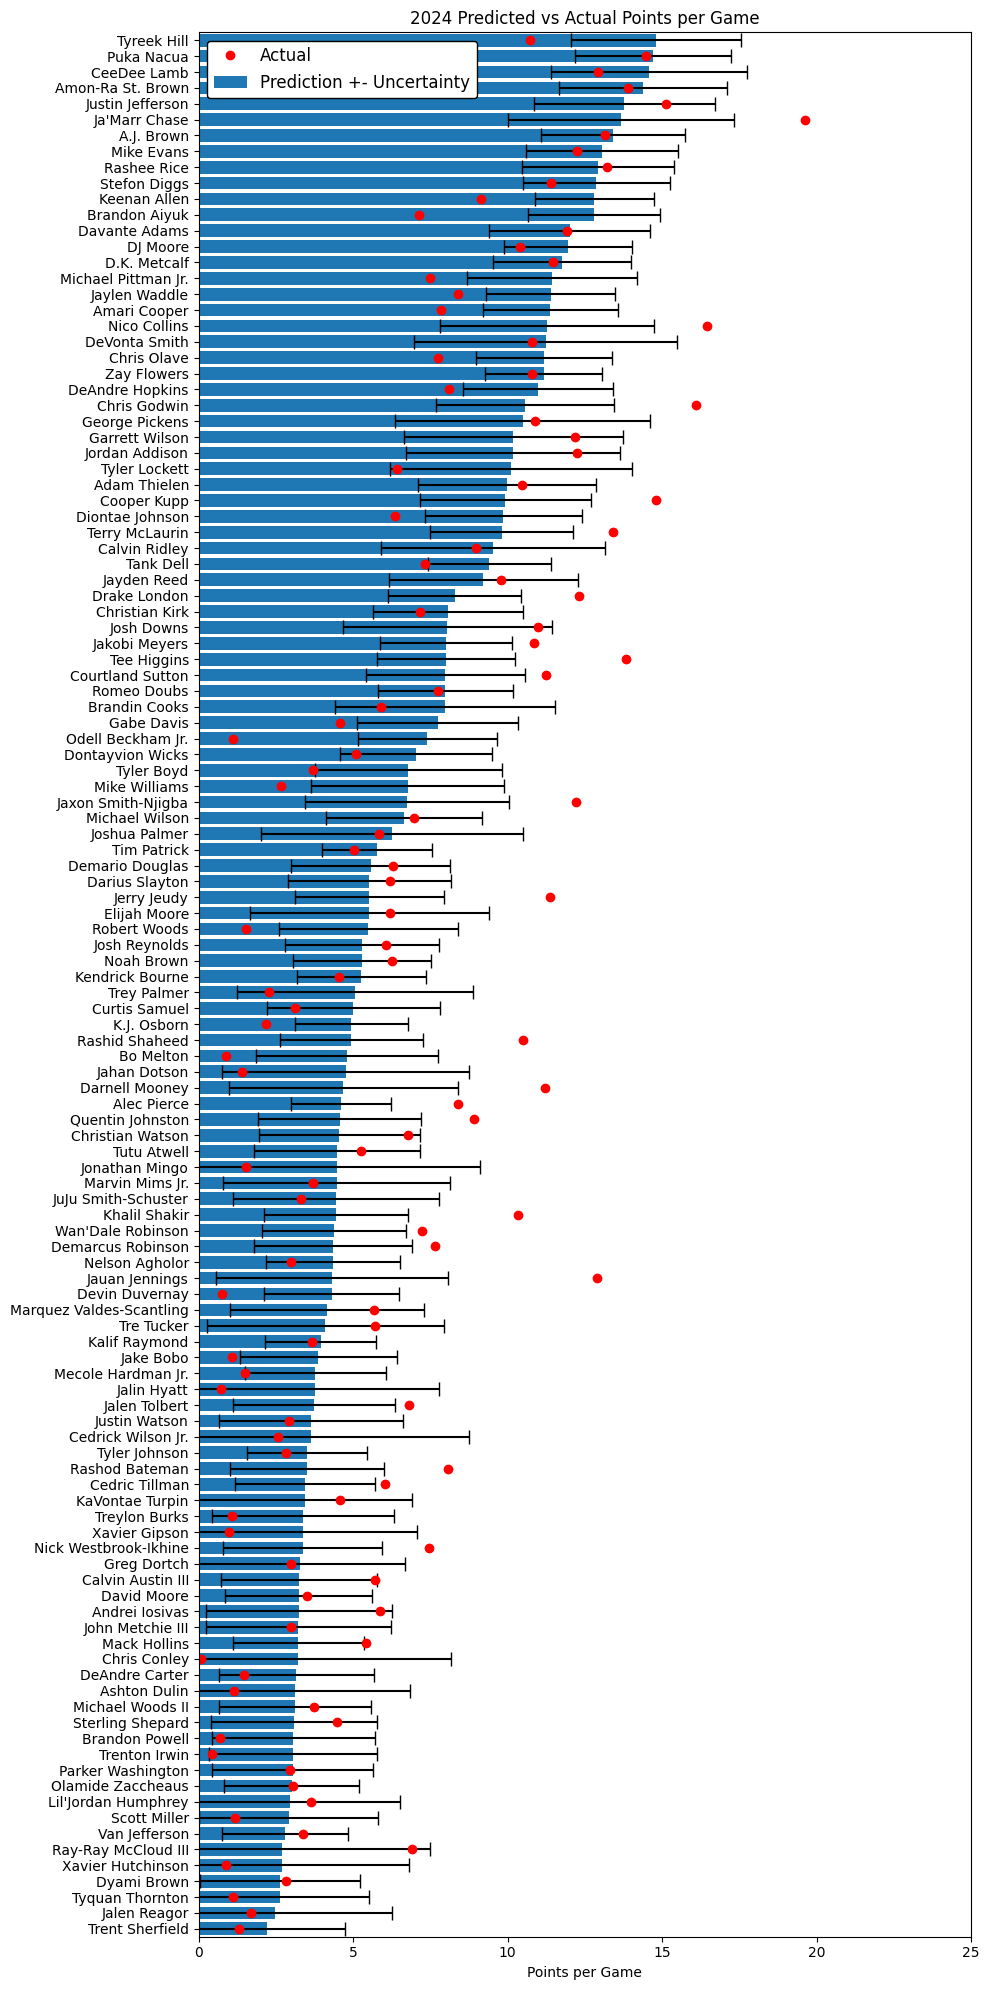

In [810]:
# display chart for 2024 drafting
nn_predictions, prediction_std = nn_avg_pred(wr_nn, nn_sig_attributes_12, layer1_size=4, output_std=True, model_iterations=10)
predictions_2024 = nn_predictions[nn_predictions['year']==2024].copy()
error = prediction_std[2024].reshape(-1,)

predictions_2024.sort_values(by='prediction',inplace=True)

plt.figure(figsize=(10,20))
plt.barh(predictions_2024['player'], predictions_2024['prediction'], xerr=error, ecolor='black', capsize=5, label='Prediction +- Uncertainty')
plt.plot(predictions_2024['actual'], predictions_2024['player'], 'o', color='red', label='Actual')
plt.ylim(-0.5, len(predictions_2024['player']) - 0.5)
plt.xlim(0,25)
plt.xlabel('Points per Game')
plt.title('2024 Predicted vs Actual Points per Game')
legend = plt.legend(loc='upper left', fontsize='large')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1)
plt.tight_layout()

## Insights and Next Steps
**Insights**

1.	8% improvement in wide receiver selection is significant.  The best fantasy football team in a league may only score 20% more points per week than the worst team.  If this same level of improvement can be extended to running backs, tight ends and quarterbacks, this model will constitute a significant competitive advantage.      
2.	There is still a high level of variability when using this model.  
    1.	There is a greater than 1 in 3 chance that using this model provides worse results than using ADP.  
    2.	The 2024 chart shows that there are significant overestimates and underestimates.
3.	There is no obvious subset of players which this model performs better or worse for, which means there are no clear routes to significant improvements.  

**Next Steps**

1.	If it is possible to identify which players are most likely to fall significantly above or below the prediction that would be valuable information for its application to drafting.  This wouldn’t improve model accuracy but would provide additional information for decision making.
2.	The quantity of collected data proved to be a significant limiting factor to the neural network.  This is easy to rectify by additional years of historical data.  This would allow additional neurons and attributes in the neural network and open the possibility of additional layers.
    1.	I am hesitant to add more than double the current historical data since that would draw data from more than 10 years ago.  There may be macroscopic trends that affect how to best predict outcomes over that time scale.
3.	Adding additional contextual data such as: if a player is on a new team, who the coach is, how good their teammates are, could provide additional insight
4.	Apply same process to running backs, tight ends and quarterbacks.


## Iteration and Learning
**External Iterations**

1.	Project started in 2021 in Excel without an understanding of data science methods.
    1.	My first attempt approximated linear regression by using linear optimization iteratively on data and residuals.
2.	From 2021-2023 focused on developing in Excel and learning better tools to develop the solution there.
    1.	Learned about excel functions for linear regression.
    2.	Learned how to measure model accuracy using R-score
3.	In 2023-2024 I migrated the model to Python to more efficiently manipulate data.
    1.	I taught myself basic Python and Pandas to do this
4.	In 2024 new I added new modeling methods like clustering and refined my implementation of linear regressions.  
    1.	Studied data science textbooks to do this
5.	In 2024-2025 I further refined my methods for data exploration, cleaning and evaluating.  I also added methods like random forests and linear regressions
    1.	Development came mostly from self-teaching
    2.	The beginning of my masters program developed my understanding of the technical and methodological components of data science. 

**Scope Iterations**

6.	At the start of the project the goal was to predict the outcome of each game for every player in every position.  This proved unattainable in Excel with available data.
7.	When migrating the project to Python I focused the scope on just wide receivers. And removed rookies from consideration for lack of data.
8.	After unsatisfactory predictions for individual game outcomes, I further narrowed the scope to predict just average points per game for the full season.  The average outcomes were much easier to predict since they had much lower variation.

**Solution Iterations**

9.	Model choice iterations
    1.	Start with simple linear regression since it is easy to implement and will give a starting point for predictive power
    2.	Created model which used clustering and then performed linear regression on those clusters to account for the different types of wide receivers and the conditions they were playing in.
    3.	Replaced this model with a random forest to address the same categorical concerns with more flexibility
    4.	Created Neural Network.  It should be able to model the interactions between different parameters to handle categorical differences and more directly create numeric predictions.
10.	 Linear Regression
    1.	Start with most likely parameters based on correlation matrix
    2.	Let model find the best parameters by starting will all available and iterating down to the top options
11.	Random Forest
    1.	Build model where the categories corresponded to integer values for points per game.  Prediction was the ‘category’ selected from those.
    2.	Updated to predict likelihood for each category and combine the results as a weighted average
12.	Neural Network
    1.	Standard learning rates of 0.01 or 0.001 were too aggressive for my model and reduced the rate until it performed as expected
    2.	Started with too many attributes to stay within appropriate parameter to data ratio.  Used all parameters and larger than allowable models with multiple iterations to find the most predictive attributes. 
    3.	Build several combinations of attribute and neuron quantities to determine which performed best.
    4.	Tried several options for number of iterations and chose the lowest value that still provided high predictive capability.
